# Predicting El Niño–Southern Oscillation through correlation and time series analysis

This example uses correlation analysis and time series analysis to predict El Niño–Southern Oscillation (ENSO) based on climate variables and indices. ENSO is an irregular periodical variation in winds and sea surface temperatures over the tropical eastern Pacific Ocean. Accurate characterization of ENSO is critical for understanding the trends and potential impacts such as droughts, floods, and tropical storms. More details can be found in the video below.

In [41]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/d6s0T0m3F8s" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>')

In climate science, ENSO is characterized through [Southern Oscillation Index](https://www.ncdc.noaa.gov/teleconnections/enso/indicators/soi/)(SOI), a standardized index based on the observed sea level pressure differences between Tahiti and Darwin, Australia. If SOI exhibits warm (greater than 0.5) or cool phase conditions for at least five consecutive values, it officially becomes an El Niño or La Niña event. Therefore, predicting SOI is the first step of ENSO forecasting. This notebooks consists of 3 sections: (1) Data exploration (2) correlation analysis; (3) Time series analysis

## Data used
The following four variables were used in this examplea as ENSO is beleived to be related to sea surface temperature, sea level pressure, precipitation, etc. 
1. Oceanic Nino Index (ONI), a climate index used for sea surface temperature (SST).
2. Eastern Tropical Pacific SST (Nino 3), another climate index used for SST focusing on a slightly different region.
3. Pacific North American Index (PNA). PNA is a closely related phenomena to ENSO.
4. Precipitation monthly mean. Historical global precipitation monthly mean in raster format.

## Part 1. Data exploration
The first three variables along with SOI has been put into a .CSV file. To give you an overview, let's read it and look at the first few lines.

In [4]:
%matplotlib inline

import numpy as np
import pandas as pd
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot

def parser(x):
    if x.endswith('11') or x.endswith('12')or x.endswith('10'):
        return datetime.strptime(x, '%Y%m')
    else:
       return datetime.strptime(x, '%Y0%m') 
df = read_csv('data/enso_original.csv', header=0, parse_dates=[0], index_col=0, date_parser=parser)
print(df.head())

            soi  oni  nino3   pna
date                             
1951-01-01  1.5 -0.8  -0.72 -1.18
1951-02-01  0.9 -0.5  -0.43 -2.11
1951-03-01 -0.1 -0.2  -0.63 -1.09
1951-04-01 -0.3  0.2   0.00  0.47
1951-05-01 -0.7  0.4  -0.12  1.19


Let us examine how SOI changes over time.

Text(0.5,0,'Time')

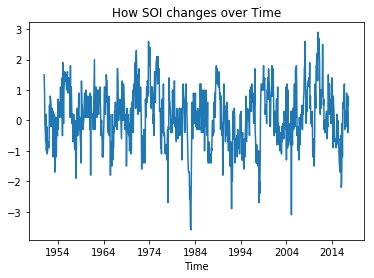

In [3]:
pyplot.plot(df.soi)
pyplot.title('How SOI changes over Time')
pyplot.xlabel('Time')

Let us put all four variables together and see how they are distributed or if there is any visual relationship.

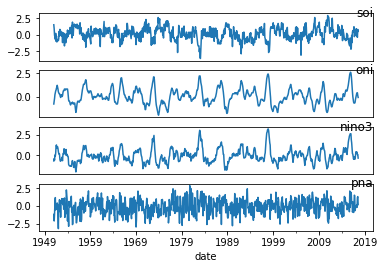

In [59]:
i = 1
fig = pyplot.figure()
for col in df.columns.tolist():
    fig.add_subplot(len(df.columns.tolist()), 1, i)
    df[col].plot()
    pyplot.title(col, y=0.8, loc='right')
    if i != len(df.columns.tolist()):
        pyplot.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
        pyplot.xlabel('')
    i += 1
pyplot.show()

As we can see, there is some relationship between the input variables (i.e., oni, nino3, pna) and output variable, soi. For example, oni and soi look high negatively correlated. We will cover how to model SOI using these variables in the time series analysis, but first let's look at how to bring in the last variable - precipitation.

## Part 2. Correlation analysis
Global precipitation monthly mean is avaialble in raster format on ArcGIS online. In this part, we will cover how to indentify the most correlated (on time dimension) grid cell through lagged correlation analysis. There are two rationals behind this. 
1. In climate science, a phenomenon that is happening now could be a result of what has happend in the past. In other words, SOI of this month could be most correlated with the ONI of last month or the month before depending on the actual physical process.
2. ENOS is a type of teleconnection which refers to climate anomalies being related to each other at large distances.

First, let us retrive the precipitation data from ArcGIS Online.

In [15]:
from arcgis.gis import GIS
agol = GIS()

In [16]:
data = agol.content.search('Global Monthly Precipitation 1979-2017')[0]
data

<Item title:"Global Monthly Precipitation 1979-2017" type:Image owner:yjiang_geosaurus>

In [17]:
data_item = agol.content.get(data.id)
# data_item.download(save_path = r'data/')

Now we have the data. Let us calculate Pearson correlation coefficient between SOI and precipitation across different latitude and longtitude (column and row) based on a range of lag values from 0 to 6.

In [42]:
from skimage import io
import math
from scipy.stats.stats import pearsonr
from numpy import unravel_index
precip_full = io.imread('data/precip.tif')

In [43]:
df.shape

(800, 4)

## Code below this point needs to be revised. The precip.tif that I converted from ArcGIS seems to be corrupted.

(37, 1) 0.6309679985210123
(36, 2) 0.496739546231217
(35, 1) 0.4525960170769308
(36, 139) 0.3931249944011725
(37, 126) 0.3917790495008859
(36, 123) 0.3461375462374744
(37, 126) 0.3411366389822607


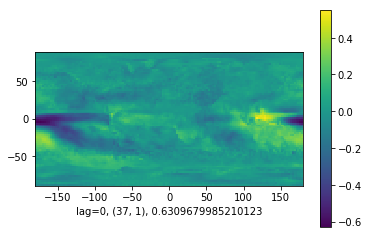

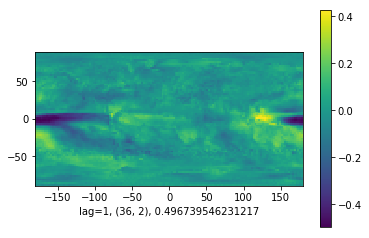

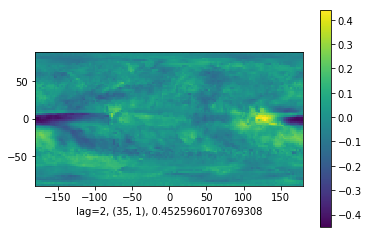

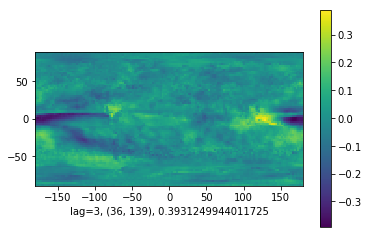

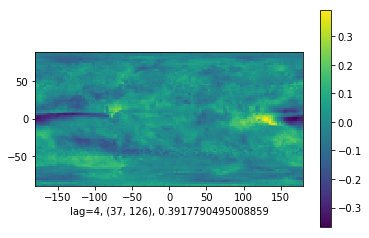

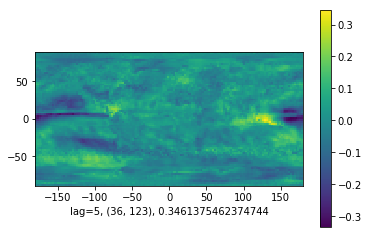

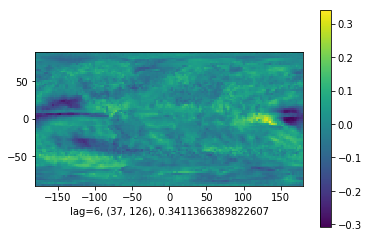

In [50]:
lag = 6
for t in range(lag+1):
    soi = df.values[336+t:-2,0]   # if t=0, soi starts from 1982    
    soi = soi.reshape(soi.shape[0], 1)

    precip = precip_full[:,:,0:-4-t]
    
    r2 = []
    for i in range(precip.shape[0]):
        for j in range(precip.shape[1]):
            r2_index = pearsonr(soi, precip[i,j,:].reshape(precip.shape[2], 1))[0]
            r2.append(r2_index)

    r2_map = np.array(r2).reshape(precip.shape[0], precip.shape[1])
    max_index = unravel_index(r2_map.argmax(), r2_map.shape)

    pyplot.figure()
    pyplot.imshow(r2_map, extent=[-180, +180, -90, 90])
    pyplot.colorbar()
    
    r2_map = np.abs(r2_map)
    max_index = unravel_index(r2_map.argmax(), r2_map.shape)
    pyplot.xlabel('lag=' + str(t) + ', ' + str(max_index) + ', ' + str(r2_map[max_index]))
    print(max_index, r2_map[max_index])
    # np.savetxt("preprocessed/enso_precipanomaly_reshaped.csv", precip[:, max_index[0], max_index[1]], '%6.2f', delimiter=",")   

In [46]:
precip_full.shape

(72, 144, 466)

In [54]:
precip_full[:,:,0]

array([[0.47171837, 0.46005923, 0.37163606, ..., 0.583462  , 0.6193359 ,
        0.5010203 ],
       [0.39780483, 0.38438904, 0.3896638 , ..., 0.52434623, 0.50328   ,
        0.45204124],
       [0.410603  , 0.35670474, 0.31044528, ..., 0.47974446, 0.48691788,
        0.4492906 ],
       ...,
       [0.25155425, 0.18179645, 0.1577379 , ..., 0.0651015 , 0.15210074,
        0.15542671],
       [0.23576902, 0.29826203, 0.29452613, ..., 0.09453225, 0.21760374,
        0.17718874],
       [0.04360015, 0.02364683, 0.07282718, ..., 0.        , 0.00393374,
        0.00496444]], dtype=float32)